# <b> Classificação Automática de Imagens de Células Sanguíneas usando Redes Neurais Convolucionais </b>

###### <b>Descrição do conjunto de dados:</b> 12.500 imagens de células sanguíneas (JPEG) acompanhadas de rótulos de tipo de célula (CSV). Este conjunto de dados é composto por cerca de 3.000 imagens para cada um dos 4 tipos de células diferentes agrupadas em 4 pastas diferentes (de acordo com o tipo de célula). Os tipos de células são:

<b>1. Eosinófilos<p></b>
<b>2. Linfócitos<p></b>
<b>3. Monócitos<p></b>
<b>4. Neutrófilos<p></b>



# <b>1. Bibliotecas</b>

In [23]:
# Manipulação de arquivos e diretórios
import os
import shutil

# Manipulação de arrays
import numpy as np

# Seleção e avaliação de modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Modelos de redes CNN
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

# Magic command (graficos abaixo das células)
%matplotlib inline

In [24]:
# Dividindo as imagens em treino, validação e teste
def split_dataset(source_folder, destination_folder, number_of_images_por_classe, train_percent, validation_percent, test_percent):
    # Crioa um novo diretório para os dados dividos
    diretorio_a_excluir = destination_folder
    if os.path.exists(diretorio_a_excluir):
        shutil.rmtree(destination_folder)
        print(f"O diretório {diretorio_a_excluir} e suas subpastas foram excluídos com sucesso!")
    
    os.makedirs(destination_folder)
    print(f"O diretório {diretorio_a_excluir} foi criado com sucesso!")
    
    # Criar pastas de destino (TRAIN, VALIDATION, TEST)
    train_folder = os.path.join(destination_folder, 'TRAIN')
    validation_folder = os.path.join(destination_folder, 'VALIDATION')
    test_folder = os.path.join(destination_folder, 'TEST')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(validation_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Listar subpastas dentro de source_folder
    subfolders = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f))]

    for label in subfolders:
        os.makedirs(os.path.join(train_folder, label), exist_ok=True)
        os.makedirs(os.path.join(validation_folder, label), exist_ok=True)
        os.makedirs(os.path.join(test_folder, label), exist_ok=True)

    for subfolder in subfolders:
        subfolder_path = os.path.join(source_folder, subfolder)
        images = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Embaralhar as imagens aleatoriamente
        random.shuffle(images)

        # Reduzindo o tamanho de cada classe
        images = images[:number_of_images_por_classe]

        # Calcular a quantidade de imagens para TRAIN, VALIDATION e TEST
        total_images = len(images)
        num_train = int(total_images * train_percent)
        num_validation = int(total_images * validation_percent)
        num_test = int(total_images * test_percent)

        # Selecionar imagens aleatórias para TRAIN, VALIDATION e TEST
        train_images = images[:num_train]
        validation_images = images[num_train:num_train + num_validation]
        test_images = images[num_train + num_validation:]

        # Copiar imagens para as pastas TRAIN, VALIDATION e TEST
        for img in train_images:
            src_path = os.path.join(subfolder_path, img)
            dst_path = os.path.join(train_folder, subfolder, img)
            shutil.copy(src_path, dst_path)
            
        for img in validation_images:
            src_path = os.path.join(subfolder_path, img)
            dst_path = os.path.join(validation_folder, subfolder, img)
            shutil.copy(src_path, dst_path)

        for img in test_images:
            src_path = os.path.join(subfolder_path, img)
            dst_path = os.path.join(test_folder, subfolder, img)
            shutil.copy(src_path, dst_path)

In [25]:
source_folder = 'Dataset'
destination_folder = 'Dataset_Divided'
number_of_images_por_classe = 250
train_percent = 0.7
validation_percent = 0.15
test_percent = 0.15

split_dataset(source_folder, destination_folder, number_of_images_por_classe, train_percent, validation_percent, test_percent)

O diretório Dataset_Divided e suas subpastas foram excluídos com sucesso!
O diretório Dataset_Divided foi criado com sucesso!


In [26]:
# Contagem dos dados
class_qnts = {}

for root, dirs, files in os.walk(source_folder):
    if root != source_folder:
        class_qnts[root.split('\\')[-1]] = len(files)


for classe, qnt in class_qnts.items():
  print(f'Classe {classe}: {qnt}'),

Classe EOSINOPHIL: 3069
Classe LYMPHOCYTE: 3102
Classe MONOCYTE: 3091
Classe NEUTROPHIL: 3123


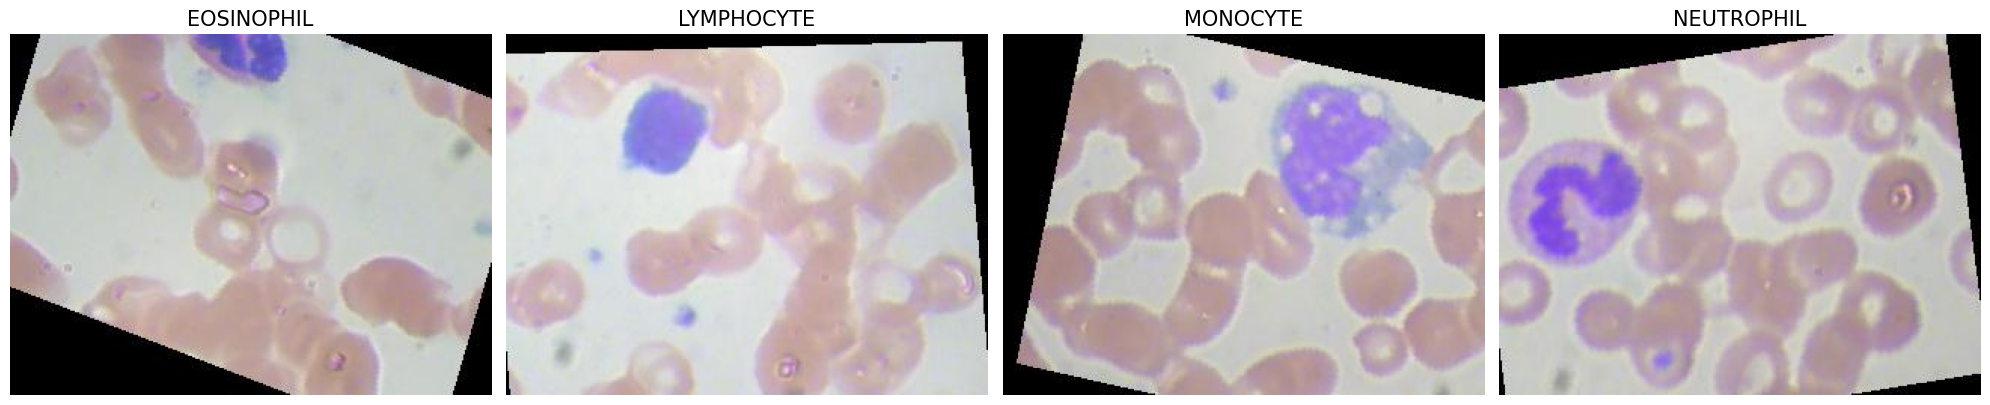

In [27]:
# Parametros para plotagem dos graficos
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

classes = os.listdir(source_folder)

for i, cell_class in enumerate(classes):

  # Imagem aleatória para n-ésima classe
  class_path = os.path.join(source_folder, cell_class)
  images = os.listdir(class_path)
  img_path = os.path.join(class_path, random.choice(images))

  # Carregando a imagem escolhida
  img = plt.imread(img_path)

  # Visualização da imagem para cada classe
  axs[i].imshow(img)
  axs[i].set_title(cell_class, fontsize=15)
  axs[i].axis('off')

plt.tight_layout()
plt.show()

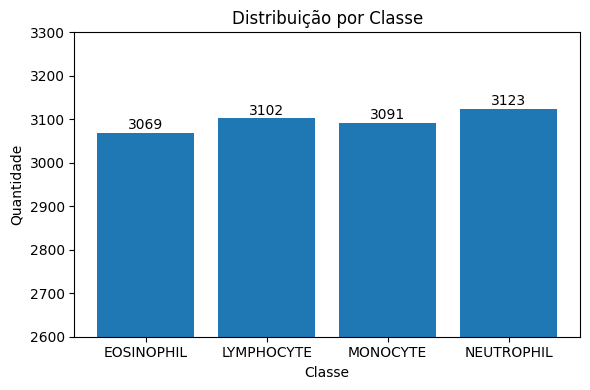

In [28]:
# Plotando a distribuição das imagens por classe
plt.figure(figsize=(6, 4))
plt.bar(class_qnts.keys(), class_qnts.values())

for i, v in enumerate(class_qnts.values()):
    plt.text(i, v+2, str(v), ha='center', va='bottom')

plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Distribuição por Classe')
plt.tight_layout()
plt.ylim(2600, 3300)
plt.show()

In [29]:
# Definindo a transformação das imagens (Pré-Processamento)

channel_means = [0.66049188, 0.64131908, 0.67861132]
channel_stds = [0.25679409, 0.25947488, 0.2599271]

def transformacao_dados(dataset):
    if dataset == "TRAIN":
        transform = transforms.Compose([
        transforms.Resize(size=(224, 224)), # Reduzindo as imagens para  224x224
        transforms.RandomHorizontalFlip(), # Inversão horizontal aleatória de imagens
        transforms.RandomRotation(degrees=15), # Rotaciona a imagem em 15°
        transforms.ToTensor(), # Converte a imagem no formato de tensor
        transforms.Normalize(mean=channel_means, std=channel_stds)
        ])

    else:
        transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=channel_means, std=channel_stds)
    ])
    return transform

In [30]:
# Carregando dados
dataloaders = {}
for name in ['TRAIN', 'VALIDATION', 'TEST']:
    dataset = ImageFolder(os.path.join(destination_folder,name),
                          transform=transformacao_dados(name))
    dataloaders[name] = DataLoader(dataset, shuffle=True,
                                   batch_size=16,
                                   num_workers=2)

In [31]:
def tensor_to_array(img, mean = (0.66049188,
                                 0.64131908,
                                 0.67861132),
                    std = (0.25679409,
                           0.25947488,
                           0.2599271)):

    np_img = img.numpy()
    np_img = np_img.transpose(1, 2 ,0)
    np_img = np_img * std + mean
    np_img = np.clip(np_img, 0, 1)

    return np_img

In [32]:
# Definindo o modelo com os pesos padrão da ResNet18
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet18_Weights

class Net(nn.Module):
    def __init__(self, freeze=True):
        super(Net, self).__init__()
        self.resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        if freeze:
            self.freeze_resnet()
        output_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(output_features, 4)

    def freeze_resnet(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.resnet(x)
        return x

In [33]:
# Hiperparâmetros
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Net(freeze=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [34]:
# Treinamento
def train(model, optimizer, criterion, train_loader, valid_loader,
          num_epochs=10, valid_loss_min=np.inf, device=device):
    callbackers = {}
    callbackers['train_loss'] = []
    callbackers['valid_loss'] = []
    callbackers['accuracy'] = []
    callbackers['f1_macro'] = []

    for e in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        #   Treinamento   #
        model.train()
        for imgs, labels in train_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            out = model.forward(imgs)
            loss = criterion(out, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*imgs.shape[0]
            
        # Avaliação do modelo
        model.eval()
        with torch.no_grad():
            targets, predictions = [], []
            for imgs, labels in valid_loader:

                imgs = imgs.to(device)
                labels = labels.to(device)
                out = model.forward(imgs)
                loss = criterion(out, labels)

                prediction = torch.argmax(out, dim = 1).cpu().numpy()
                target = labels.cpu().numpy()

                predictions.extend(prediction)
                targets.extend(target)
                valid_loss += loss.item()*imgs.shape[0]

        # calculando métricas
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        acc = accuracy_score(predictions, targets)
        f1_macro = f1_score(predictions, targets, average='macro')

        # imprimindo valores
        print(f'Epoch: {e+1} TrainLoss: {train_loss:.3f} ValidLoss: {valid_loss:.3f} ACC: {acc:.3f} F1_MACRO: {f1_macro}')

        # salvando métricas
        callbackers['train_loss'].append(train_loss)
        callbackers['valid_loss'].append(valid_loss)
        callbackers['accuracy'].append(acc)
        callbackers['f1_macro'].append(f1_macro)

        # salvando o modelo

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'ResNet18.pt')
            valid_loss_min = valid_loss

    return callbackers

In [35]:
train_stats = train(model, optimizer, criterion, dataloaders["TRAIN"], dataloaders["VALIDATION"])

Epoch: 1 TrainLoss: 1.543 ValidLoss: 19.740 ACC: 0.250 F1_MACRO: 0.1
Epoch: 2 TrainLoss: 0.988 ValidLoss: 2.291 ACC: 0.432 F1_MACRO: 0.2893132872815929
Epoch: 3 TrainLoss: 0.822 ValidLoss: 0.631 ACC: 0.696 F1_MACRO: 0.6525121603001478
Epoch: 4 TrainLoss: 0.874 ValidLoss: 0.834 ACC: 0.635 F1_MACRO: 0.6026004103962637
Epoch: 5 TrainLoss: 0.642 ValidLoss: 0.577 ACC: 0.804 F1_MACRO: 0.8029927733556766
Epoch: 6 TrainLoss: 0.802 ValidLoss: 0.977 ACC: 0.581 F1_MACRO: 0.5015044814340589
Epoch: 7 TrainLoss: 0.640 ValidLoss: 82.658 ACC: 0.250 F1_MACRO: 0.1
Epoch: 8 TrainLoss: 0.594 ValidLoss: 0.489 ACC: 0.804 F1_MACRO: 0.7984960907080334
Epoch: 9 TrainLoss: 0.510 ValidLoss: 1.549 ACC: 0.642 F1_MACRO: 0.589078166419976
Epoch: 10 TrainLoss: 0.536 ValidLoss: 1.003 ACC: 0.669 F1_MACRO: 0.604478261292267


In [36]:
# Avaliação
def evaluate(model, criterion, test_loader, device=device):
    model.eval()
    with torch.no_grad():
        targets, predictions = [], []
        overall_loss = 0
        for imgs, labels in test_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)
            out = model.forward(imgs)
            loss = criterion(out, labels)
            prediction = torch.argmax(out, dim = 1).cpu().numpy()
            target = labels.cpu().numpy()

            targets.extend(target)
            predictions.extend(prediction)

            overall_loss += loss.item()*imgs.shape[0]

        overall_loss /= len(test_loader.sampler)
        accuracy = accuracy_score(targets, predictions)
        f1_macro = f1_score(targets, predictions, average='macro')
        return {'targets': targets,
                'predictions': predictions,
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'loss': overall_loss
                }

In [37]:
test_stats = evaluate(model, criterion, dataloaders["TEST"])

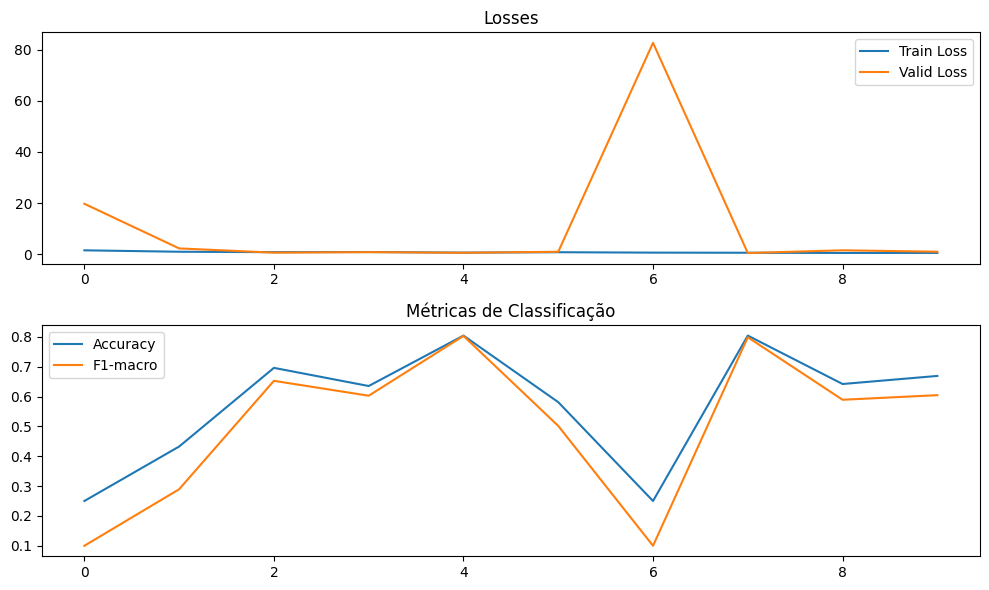

In [38]:
fig, ax =  plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(train_stats['train_loss'], label='Train Loss')
ax[0].plot(train_stats['valid_loss'], label='Valid Loss')
ax[0].set_title('Losses')
ax[0].legend()
ax[1].plot(train_stats['accuracy'], label='Accuracy')
ax[1].plot(train_stats['f1_macro'], label='F1-macro')
ax[1].set_title('Métricas de Classificação')
ax[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
def draw_confusion(targets, predictions):
    confusion = confusion_matrix(targets, predictions)
    plt.figure(figsize=(7, 7))
    sns.heatmap(confusion, annot=True, cbar=False,
                xticklabels=classes,
                yticklabels=classes)
    plt.ylabel('Classe Predita')
    plt.xlabel('Classe Real')
    plt.show()

In [ ]:
draw_confusion(test_stats["targets"], test_stats["predictions"])

In [ ]:
#Final results

print('Test Loss:', test_stats['loss'])
print('Test Accuracy:', test_stats['accuracy'])
print('Test F1 Macro:', test_stats['f1_macro'])